In [448]:
import matplotlib.pyplot as plt
import numpy as np
from mpmath import mpf, mp

In [449]:
mp.dps = 100

In [450]:
#reading data
path = "dataset_NB.txt"
data = []
with open(path) as f:
    data.append(f.readlines())

In [451]:
data1 = data[0]
len(data1)

1000

In [452]:
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''

In [453]:
#tokenising the given data to rid them of punctuation marks
def token(data):
    
    data_n = []
    
    l = len(data)
    
    for i in range(l):
        lis = []
        string = data1[i].split()
        yi = [string[-1]]
        slen = len(string)
        for j in range(slen - 1):
            s1 = ""
            if string[j] not in punc:
                for e in string[j]:
                    if e not in punc:
                        s1 = s1 + e
            lis.append(s1)
                                              
        data_n.append([lis, yi])
        
    data_np = np.array(data_n)
        
    return data_np

In [454]:
data_np = token(data1)

In [455]:
def dict_w(data_tr, alpha):
    #dictionary of the words
    # key : word
    #value : [freq_in_nonspam, freq_inspam, tot_count]
    dic_w = {}
    ld = len(data_tr)
    #total words
    N = 0
    Y = 0
    No = 0
    #number of spam and nonspam words
    spam = 0
    nspam = 0
    for i in range(ld):
        data = data_tr[i]
        for a in data:
            yl = a[1][0]
            if yl == "0":
                nspam = nspam + 1
            elif yl == "1":
                spam = spam + 1
            wl = a[0]
            for word in wl:
                N = N + 1
                if word not in dic_w.keys():
                    if yl == "0":
                        dic_w[word] = [1, 0, 1]
                    elif yl == "1":
                        dic_w[word] = [0, 1, 1]
                else:
                    #computing frequencies of the words
                    if yl == "0":
                        dic_w[word][0] = dic_w[word][0] + 1
                    elif yl == "1":
                        dic_w[word][1] = dic_w[word][1] + 1
                    dic_w[word][2] = dic_w[word][2] + 1
    
    #total frequency of spam and nonspam words               
    for word in dic_w.keys():
        No = No + dic_w[word][0]
        Y = Y + dic_w[word][1]
    
    #probabilties of word being nonspam, spam and total probability
    for word in dic_w.keys():
        dic_w[word][0] = (dic_w[word][0] + alpha)/(No + len(dic_w)*alpha)
        dic_w[word][1] = (dic_w[word][1] + alpha)/(Y + len(dic_w)*alpha)
        dic_w[word][2] = (dic_w[word][2] + alpha)/(N + len(dic_w)*alpha)
    
    lisp = [dic_w, spam, nspam]

    return lisp

In [456]:
def k_val_fit(data_trial, k, alpha):
    #grouping the data into k folds
    # alpha is the laplace smoothening rate
#     np.random.shuffle(data_trial)
    data_g = np.array_split(data_trial, k)
    #accuracy for training data and testing data
    nb_accuracy = {}
    nbtr_accuracy = {}
    tr_acc = {}
    for i in range(k):
        data_tes = data_g[i]
        data_tr = []
        lenm = 0
        for j in range(k):
            if j!=i:
                data_tr.append(data_g[j])
                lenm = lenm + len(data_g[j])
        #computing the dictonary for each fold
        lisp = dict_w(data_tr, alpha)
        dicti_w = lisp[0]
        spam = lisp[1]
        nspam = lisp[2]
        #probabilty of spam and nonspam
        #class probability
        P0 = mpf(nspam)/(lenm)
        P1 = mpf(spam)/(lenm)
        
        count = 0
        count1 = 0
        nt = 0
        countd = 0
        for d in data_tr: 
            
            for ar1 in d:
                countd = countd + 1
                ytrue = float(ar1[1][0])
                wlt = ar1[0]
                #probability of word given its spam/nonspam
                #prior probability
                Pw0 = 1
                Pw1 = 1
                Pw = 1
                for word in wlt:
                    if word in dicti_w.keys():
                        lisw = dicti_w[word]
                        Pw0 = Pw0*mpf(lisw[0])
                        Pw1 = Pw1*mpf(lisw[1])
                        Pw = Pw*mpf(lisw[2])
                    else:
                        #laplace smoothening
                        Pw0 = Pw0*(alpha/(alpha*len(dicti_w)))
                        Pw1 = Pw1*(alpha/(alpha*len(dicti_w)))
                        Pw = Pw*(alpha/(alpha*len(dicti_w)))
                #probability that the word is spam/nonspam
                #posterior probabilty
                Py0 = (mpf(Pw0)*mpf(P0))/mpf(Pw)
                Py1 = (mpf(Pw1)*mpf(P1))/mpf(Pw)
                py0 = mpf(Py0)/(mpf(Py0) + mpf(Py1))
                py1 = mpf(Py1)/(mpf(Py0) + mpf(Py1))
                
                #prediction 
                if py0>py1:
                    ypred = float(0)
                elif py1>=py0:
                    ypred = float(1)
                if ypred == ytrue:
                    count1 = count1 + 1
                    
            accuracy = (count1/countd)*100
            stringi = "train" + str(nt)
            nbtr_accuracy[stringi] = accuracy 
            nt = nt + 1
        s = "train" + str(i)
        av = sum(nbtr_accuracy.values()) / len(nbtr_accuracy)
        tr_acc[s] = av
       
        
        for ar in data_tes:   

            ytrue = float(ar[1][0])
            wlt = ar[0]
            #probability of word given its spam/nonspam
            #prior probability
            Pw0 = 1
            Pw1 = 1
            Pw = 1
            for word in wlt:
                if word in dicti_w.keys():
                    lisw = dicti_w[word]
                    Pw0 = Pw0*mpf(lisw[0])
                    Pw1 = Pw1*mpf(lisw[1])
                    Pw = Pw*mpf(lisw[2])
                else:
                    #laplace smoothening
                    Pw0 = Pw0*(alpha/(alpha*len(dicti_w)))
                    Pw1 = Pw1*(alpha/(alpha*len(dicti_w)))
                    Pw = Pw*(alpha/(alpha*len(dicti_w)))
            #probability that the word is spam/nonspam
            #posterior probabilty       
            Py0 = (mpf(Pw0)*mpf(P0))/mpf(Pw)
            Py1 = (mpf(Pw1)*mpf(P1))/mpf(Pw)
            py0 = mpf(Py0)/(mpf(Py0) + mpf(Py1))
            py1 = mpf(Py1)/(mpf(Py0) + mpf(Py1))
            
            #prediction 
            if py0>py1:
                ypred = float(0)
            elif py1>=py0:
                ypred = float(1)
            if ypred == ytrue:
                count = count + 1

        accuracy = (count/len(data_tes))*100
        stringi = "test" + str(i)
        nb_accuracy[stringi] = accuracy
    #returns accuracy for training and test data 
    return [tr_acc, nb_accuracy]

In [457]:
alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# alphas = [0.8]
# alphas = [0.2,0.4,0.6,1.0]
accuracies_alpha = []
accuraciestr_alpha = []
accuracies = []
accuraciestr = []
for alpha in alphas:
    maxx = 0.0
    maxxtr = 0.0
    try:
        lisa = k_val_fit(data_np, 7, alpha)
        
        print("For alpha = {} the accuracies :".format(alpha))
        print("Training data :")
        for key, value in lisa[0].items(): 
            k = key
            a = value 
            print ("{:<10} {:<10}".format(k, a))
        print("Testing data :")
        for key, value in lisa[1].items(): 
            k = key
            a = value 
            print ("{:<10} {:<10}".format(k, a)) 
        
        train_avg = sum(lisa[0].values()) / len(lisa[0]) 
        test_avg = sum(lisa[1].values()) / len(lisa[1])
        
        print("Avg training accuracy : ",train_avg)
        print("Avg test accuracy : ",test_avg)
        print('\n')
        
        #finding the max probability in each fold
        nbtr_accu = lisa[0]
        nb_accu = lisa[1]
        for key in nb_accu.keys():
            if nb_accu[key]>maxx:
                maxx = nb_accu[key]
        accuracies_alpha.append([key, alpha, maxx])
        accuracies.append(maxx)
        for key in nbtr_accu.keys():
            if nbtr_accu[key]>maxxtr:
                maxxtr = nbtr_accu[key]
        accuraciestr_alpha.append([key, alpha, maxxtr])
        accuraciestr.append(maxxtr)
        #exception for when alpha is 0
    except ZeroDivisionError as e:
        accuracies_alpha.append([alpha, maxx])
        accuracies.append(maxx)
        accuraciestr_alpha.append([alpha, maxxtr])
        accuraciestr.append(maxxtr)
        print("Division by zero")

Division by zero
For alpha = 0.1 the accuracies :
Training data :
train0     99.23442757165044
train1     98.9721671431123
train2     99.3878852251081
train3     99.14699231793747
train4     99.12758996481284
train5     99.17425534403365
train6     98.76456876456876
Testing data :
test0      79.72027972027972
test1      83.21678321678321
test2      79.72027972027972
test3      78.32167832167832
test4      77.62237762237763
test5      78.32167832167832
test6      79.5774647887324
Avg training accuracy :  99.11541233303193
Avg test accuracy :  79.50007738740133


For alpha = 0.2 the accuracies :
Training data :
train0     99.1430846477521
train1     98.92940943407689
train2     99.04984455451199
train3     99.14699231793747
train4     99.10814227908743
train5     99.17425534403365
train6     98.57614607614607
Testing data :
test0      80.41958041958041
test1      83.21678321678321
test2      79.02097902097903
test3      79.02097902097903
test4      78.32167832167832
test5      79.0209790

In [458]:
#print maximum accuracy in testdata for each alpha
print("Max accuracy in testdata for every alpha :")
for i in range(len(accuracies_alpha)):
    print(accuracies_alpha[i])

Max accuracy in testdata for every alpha :
[0.0, 0.0]
['test6', 0.1, 83.21678321678321]
['test6', 0.2, 83.21678321678321]
['test6', 0.3, 82.51748251748252]
['test6', 0.4, 81.11888111888112]
['test6', 0.5, 82.51748251748252]
['test6', 0.6, 82.51748251748252]
['test6', 0.7, 83.91608391608392]
['test6', 0.8, 83.91608391608392]
['test6', 0.9, 83.91608391608392]
['test6', 1.0, 83.91608391608392]


In [459]:
#print maximum accuracy in traindata for each alpha
print("Max accuracy in traindata for every alpha :")
for i in range(len(accuraciestr_alpha)):
    print(accuraciestr_alpha[i])

Max accuracy in traindata for every alpha :
[0.0, 0.0]
['train6', 0.1, 99.3878852251081]
['train6', 0.2, 99.17425534403365]
['train6', 0.3, 99.03624704091449]
['train6', 0.4, 98.97794931633905]
['train6', 0.5, 98.85751419590395]
['train6', 0.6, 98.78561895773099]
['train6', 0.7, 98.57384091339752]
['train6', 0.8, 98.74286124869555]
['train6', 0.9, 98.74286124869555]
['train6', 1.0, 98.57384091339752]


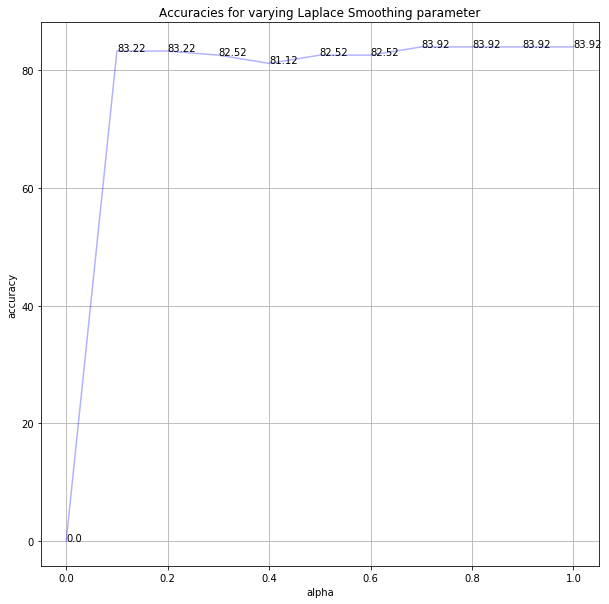

In [460]:
#plotting accuracy vs alpha
fig = plt.figure(figsize = (10, 10))
plt.plot(alphas, accuracies, c = "b", alpha = 0.3)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracies for varying Laplace Smoothing parameter")
plt.grid()
for i, accu in enumerate(accuracies):
    plt.annotate(round(accu, 2), (alphas[i], accuracies[i]))
plt.show()